In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from statsmodels.stats.anova import AnovaRM
from sklearn.metrics import precision_recall_fscore_support

In [44]:
root_path = os.path.abspath(os.path.join('..', '..'))
train_device_1 = 'RLA-ideal'  # Also the test device
train_device_2 = 'RLA-self'
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
           26, 27, 28, 29, 30, 31, 32, 33]
train_keys = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [45]:
# Method used for getting the right path for a model based on the device name and the cv number
'''
root_path: the root path of the project
device: the device name
cv: the cross validation number

Acceptable model types: attend, deepconv, tinyhar
'''


def get_model_path(root_path, variant, model_type, cv):
    path = root_path
    parent_path = os.path.join(path, 'data', 'Run_logs', variant, 'logs')
    # parent paths has three folders for attend, deepCONV, TinyHAR. Get a list of all folders in the parent path
    folders = os.listdir(parent_path)
    for folder in folders:
        if model_type in folder:
            path = os.path.join(parent_path, folder)
            break
    # path now has the path to the model type folder
    path = os.path.join(path, 'cv_' + str(cv))
    return path


def get_result_for_model(root_path, model_variant, test_variant, model_type, cv):
    path = get_model_path(root_path, model_variant, model_type, cv)
    filename = 'prediction_result_' + model_variant + '_' + test_variant + '.csv'
    path = os.path.join(path, filename)
    # open the csv file prediction_result_ and read the data
    csv_file = path
    # open with pandas
    df = pd.read_csv(csv_file)
    # if the file is empty, continue
    if df.empty:
        return None

    # get the prediction result
    preds = df['preds'].values
    # get the ground truth
    trues = df['trues'].values

    num_classes = 34
    classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
               26, 27, 28, 29, 30, 31, 32, 33]

    # Calculate precision, recall, and f1 for each class. Use zero devision as 0
    precision, recall, f1_weighted, _ = precision_recall_fscore_support(trues, preds, labels=classes,
                                                                        average='weighted', zero_division=0)
    # Calculate macro
    _, _, f1_macro, _ = precision_recall_fscore_support(trues, preds, labels=classes, average='macro', zero_division=0)

    # # create confusion matrix
    # cm = confusion_matrix(trues, preds, labels=classes)
    # # plot the confusion matrix
    # plt.figure(figsize=(10, 10))
    # sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    # plt.xlabel('Predicted')
    # plt.ylabel('True')
    # plt.title('Confusion Matrix')
    # plt.show()

    # Calculate accuracy
    accuracy = np.sum(preds == trues) / len(preds)

    return accuracy, precision, recall, f1_macro, f1_weighted  #, preds, trues


def create_confusion_matrix(root_path, model_variant, test_variant, model_type, cv):
    path = get_model_path(root_path, model_variant, model_type, cv)
    filename = 'prediction_result_' + model_variant + '_' + test_variant + '.csv'
    path = os.path.join(path, filename)
    # open the csv file prediction_result_ and read the data
    csv_file = path
    # open with pandas
    df = pd.read_csv(csv_file)
    # if the file is empty, continue
    if df.empty:
        return None

    # get the prediction result
    preds = df['preds'].values
    # get the ground truth
    trues = df['trues'].values

    # create confusion matrix
    cm = confusion_matrix(trues, preds, labels=classes)
    # plot the confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

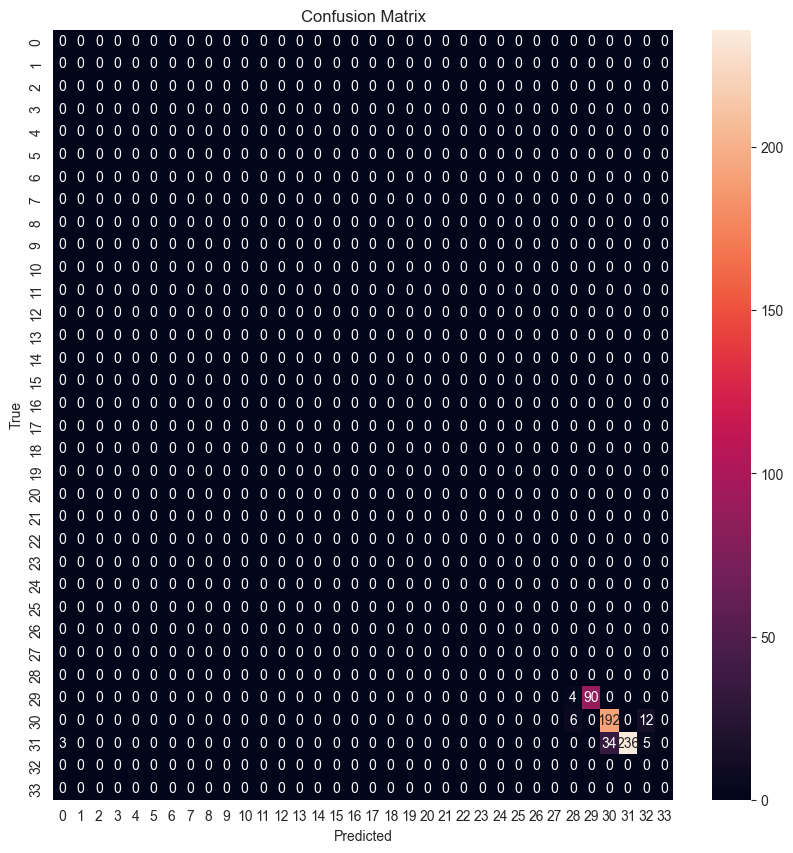

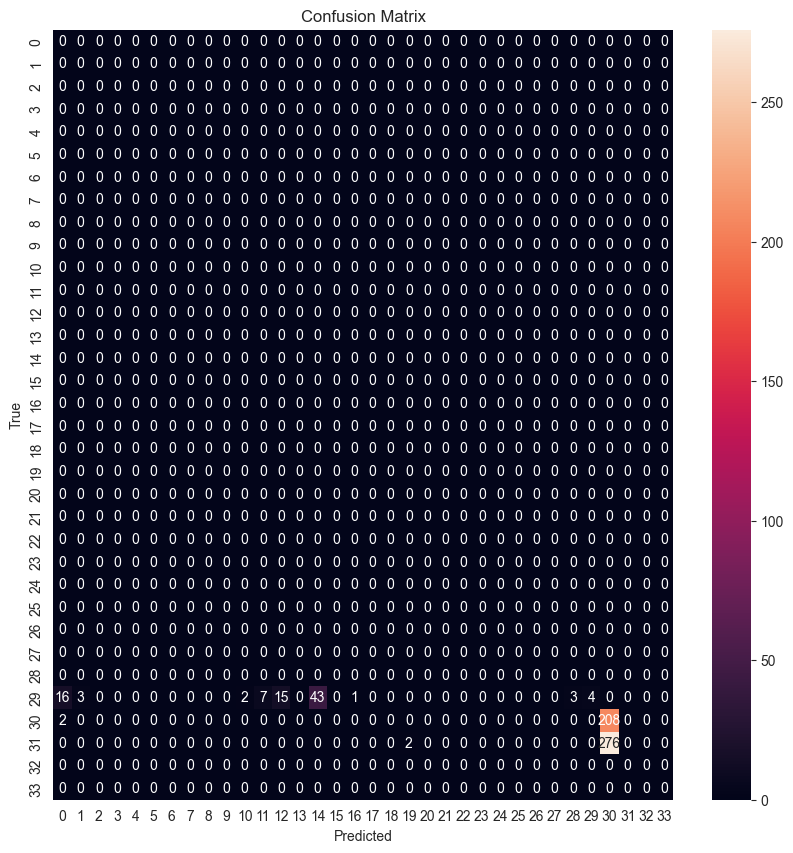

In [46]:
graph_cv = 6
graph_model = 'tinyhar'
create_confusion_matrix(root_path, train_device_1, train_device_1, graph_model, graph_cv)
create_confusion_matrix(root_path, train_device_2, train_device_1, graph_model, graph_cv)

## 1 v 1 Graphs and Info

Participant:  0
Participant:  1
Participant:  2
Participant:  3
Participant:  4
Participant:  5
Participant:  6
Participant:  7
Participant:  8
Participant:  9
Participant:  10
Participant:  11
Participant:  12
Participant:  13
Participant:  14
Participant:  15
Participant:  16
           f1  cv  device_config model_type
5    0.484406   0  self vs ideal    tinyhar
11   0.583424   1  self vs ideal    tinyhar
17   0.408562   2  self vs ideal    tinyhar
23   0.506146   3  self vs ideal    tinyhar
29   0.456895   4  self vs ideal    tinyhar
35   0.413870   5  self vs ideal    tinyhar
41   0.020031   6  self vs ideal    tinyhar
47   0.389469   7  self vs ideal    tinyhar
53   0.520237   8  self vs ideal    tinyhar
59   0.592691   9  self vs ideal    tinyhar
65   0.460720  10  self vs ideal    tinyhar
71   0.548595  11  self vs ideal    tinyhar
77   0.381031  12  self vs ideal    tinyhar
83   0.551766  13  self vs ideal    tinyhar
89   0.472406  14  self vs ideal    tinyhar
95   0.326936  15

D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


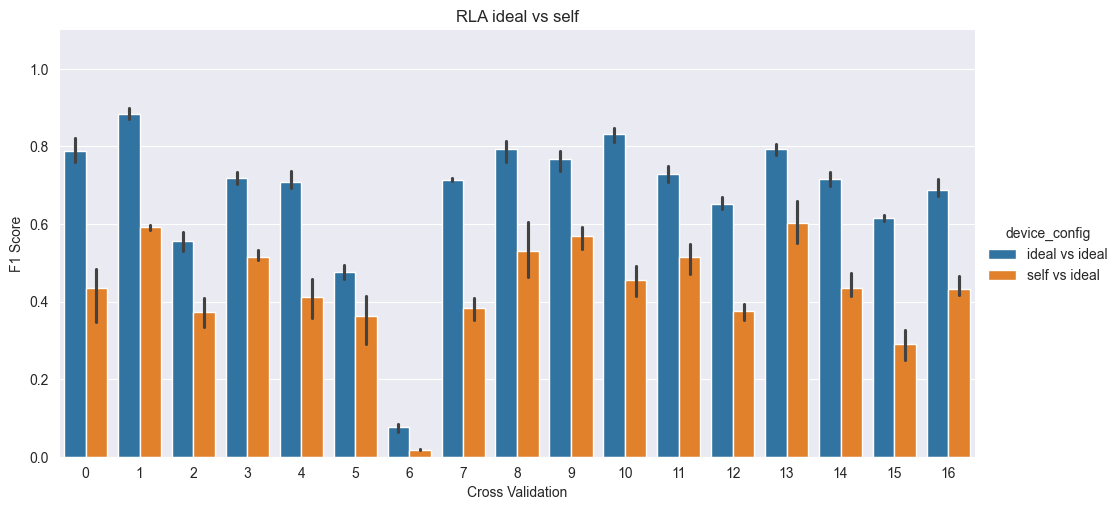

In [47]:
# Blue sense rwr1 vs rwr2
result_list = []

for i in train_keys:
    print('Participant: ', i)
    for model in ['attend', 'deepconv', 'tinyhar']:
        result1 = get_result_for_model(root_path, train_device_1, train_device_1, model, i)
        result2 = get_result_for_model(root_path, train_device_2, train_device_1, model, i)
        dict_results = {'f1': result1[3],
                        'cv': i,
                        'device_config': 'ideal vs ideal', 'model_type': model}
        result_list.append(dict_results)
        dict_results = {'f1': result2[3],
                        'cv': i,
                        'device_config': 'self vs ideal', 'model_type': model}
        result_list.append(dict_results)

df = pd.DataFrame(result_list)
# print only rwr1 vs rwr1 and model deepconv
print(df[(df['device_config'] == 'self vs ideal') & (df['model_type'] == 'tinyhar')])

# plot the f1 score for all participants as bar graph using sns catplot bar
sns.catplot(x='cv', y='f1', hue='device_config', data=df, kind='bar', aspect=2, height=5)
plt.title('RLA ideal vs self')
plt.xlabel('Cross Validation')
plt.ylabel('F1 Score')
# plot max y value is 1.1
plt.ylim(0, 1.1)
plt.show()


In [48]:
# Method for creating a multi bar graph with x axis and y axis values in the for of a list
'''
x: list of x axis labels
y: list of y axis values
x_label: x axis label
y_label: y axis label
title: title of the graph
width: width of the graph
height: height of the graph
bar_width: width of each bar
'''


def generate_multi_bar_graph(data_frame, x_label, y_label, title, width, height, bar_width, std=False):
    # set the width of the bars
    bar_width = bar_width
    sns.barplot(data_frame, x=x_label, y=y_label, palette='dark', errorbar='sd' if std else None)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(0, 1)
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.gcf().set_size_inches(width, height)
    plt.show()


def get_f1_df(model_device, test_device):
    data = {'Device': [], 'F1 Score': [], 'model_type': [], 'cv': []}
    df = pd.DataFrame(data)

    for i in train_keys:
        new_row = {'Device': test_device,
                   'F1 Score': get_result_for_model(root_path, model_device, test_device, 'attend', i)[3],
                   'model_type': 'attend',
                   'cv': i}
        df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
        new_row = {'Device': test_device,
                   'F1 Score': get_result_for_model(root_path, model_device, test_device, 'deepconv', i)[3],
                   'model_type': 'deepconv',
                   'cv': i}
        df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
        new_row = {'Device': test_device,
                   'F1 Score': get_result_for_model(root_path, model_device, test_device, 'tinyhar', i)[3],
                   'model_type': 'tinyhar',
                   'cv': i}
        df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
    return df


def generate_graph_with_std(root_path, model_device, test_devices):
    df = get_f1_df(model_device, test_devices)

    # generate the graph
    g = sns.catplot(x='Device', y='F1 Score', hue='model_type', data=df, kind='bar', palette='dark', errorbar='sd',
                    alpha=.6, height=6, aspect=2).set(title='F1 Score for Model trained with ' + model_device)
    g.despine(left=True)
    g.set_ylabels('F1 Score')
    g.set_xlabels('Device')
    g.set_xticklabels(rotation=45)

    # save the graph in folder mean_graphs in the logs, create folder if not exists
    if not os.path.exists(os.path.join(root_path, 'data', 'Run_logs', model_device, 'logs', 'mean_graphs')):
        os.makedirs(os.path.join(root_path, 'data', 'Run_logs', model_device, 'logs', 'mean_graphs'))
    # plt.savefig(os.path.join(root_path, 'data', 'Run_logs', model_device, 'logs', 'mean_graphs',
    #                          'F1 Score for Model trained with ' + model_device + '.png'))




In [49]:
# generate_graph_with_std(root_path, sensor1', test_devices)

## MMD Graphs

In [65]:
def generate_delta_mmd_graph(device1, device2, model_type):
    '''
        The graph is generated between the mmd difference between two device for each cv:
        For example:
        With variation = mmd of (cv2): device2 p001 and device1 (all_p0* - p001)
        Without variation = mmd of (cv2): device1 p001 and device1 (all_p0* - p001)

        VS

        The f1 score difference between two train test set:
        Set 1: Train = device1 (all_p0* - p001) Test = device1 p001
        Set 2: Train = device1 (all_p0* - p001) Test = device2 p001
    '''
    # read the mmd values from the csv
    path = os.path.join(root_path, 'data', 'mmd', 'mmd_results_' + device1 + '_' + device1 + '.csv')
    df_1_1 = pd.read_csv(path)
    # print(df_1_1)
    path = os.path.join(root_path, 'data', 'mmd', 'mmd_results_' + device2 + '_' + device1 + '.csv')
    df_2_1 = pd.read_csv(path)
    # print(df_2_1)
    # get the magnitude from Acc_X, Acc_Y, Acc_Z for both df
    df_1_1['magnitude'] = ((df_1_1['Acc_X']) ** 2 + (df_1_1['Acc_Y']) ** 2 + (
        df_1_1['Acc_Z']) ** 2) ** 0.5
    df_2_1['magnitude'] = ((df_2_1['Acc_X']) ** 2 + (df_2_1['Acc_Y']) ** 2 + (
        df_2_1['Acc_Z']) ** 2) ** 0.5

    delta_mag = (df_2_1['magnitude'] - df_1_1['magnitude'])
    # rename the column
    delta_mag = delta_mag.rename('delta_mag')
    f1_1_1 = get_f1_df(device1, device1)
    f1_2_1 = get_f1_df(device2, device1)
    f1_1_1 = f1_1_1[f1_1_1['model_type'] == model_type]
    f1_2_1 = f1_2_1[f1_2_1['model_type'] == model_type]
    # mean all values with same value in column cv
    mean_f1_1_1 = f1_1_1.groupby('cv')['F1 Score'].mean().reset_index()
    mean_f1_2_1 = f1_2_1.groupby('cv')['F1 Score'].mean().reset_index()

    # drop the cv column
    mean_f1_1_1 = mean_f1_1_1.drop(columns=['cv'])
    mean_f1_2_1 = mean_f1_2_1.drop(columns=['cv'])
    delta_mean_f1 = mean_f1_2_1 - mean_f1_1_1

    df_delta_mmd_and_f1 = pd.concat([delta_mag, delta_mean_f1], axis=1)
    # add column cv running 0 to num_participants
    df_delta_mmd_and_f1['cv'] = train_keys
    # plot df_delta_mmd_and_f1
    plt.scatter(df_delta_mmd_and_f1['delta_mag'], df_delta_mmd_and_f1['F1 Score'])
    for i in train_keys:
        plt.annotate(i, (delta_mag[i], delta_mean_f1.iloc[i]))
    # sort the values on the basis of delta_mag
    df_delta_mmd_and_f1 = df_delta_mmd_and_f1.sort_values(by='delta_mag')
    # plot the line
    plt.plot(df_delta_mmd_and_f1['delta_mag'], df_delta_mmd_and_f1['F1 Score'])

    plt.xlabel('delta_mmd')
    plt.ylabel('delta_mean_f1')
    # set max y to 0.5 and min y to -0.5
    plt.ylim(-0.6, 0.1)
    plt.title('delta_mmd vs delta_mean_f1 for ' + device1 + ' and ' + device2)

D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


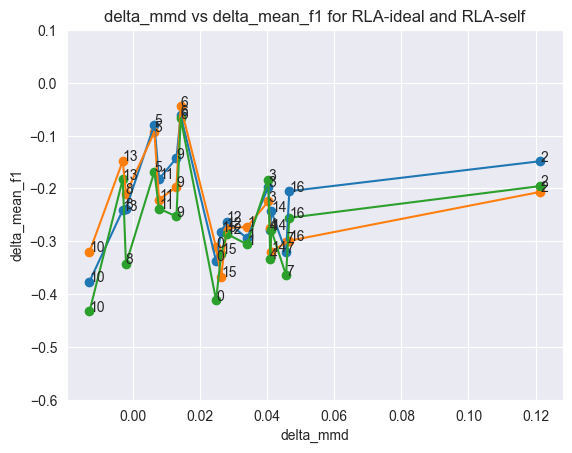

In [66]:
generate_delta_mmd_graph(train_device_1, train_device_2, 'tinyhar')
generate_delta_mmd_graph(train_device_1, train_device_2, 'deepconv')
generate_delta_mmd_graph(train_device_1, train_device_2, 'attend')

D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


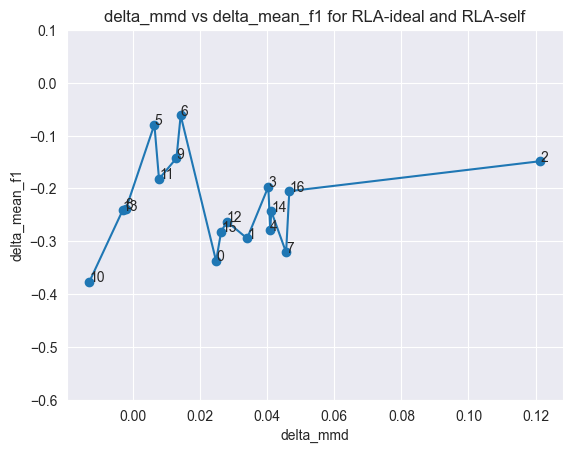

In [67]:
generate_delta_mmd_graph(train_device_1, train_device_2, 'tinyhar')

D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


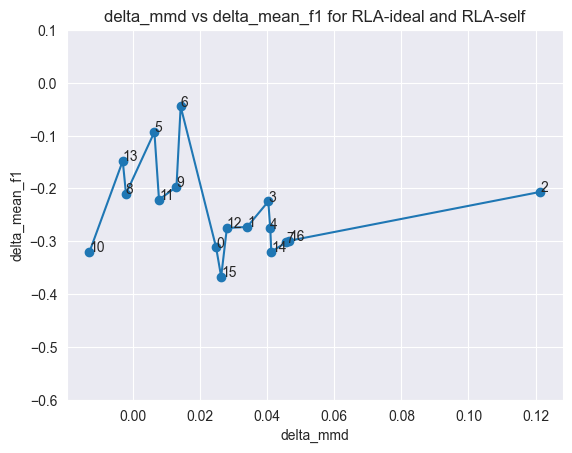

In [68]:
generate_delta_mmd_graph(train_device_1, train_device_2, 'deepconv')

D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


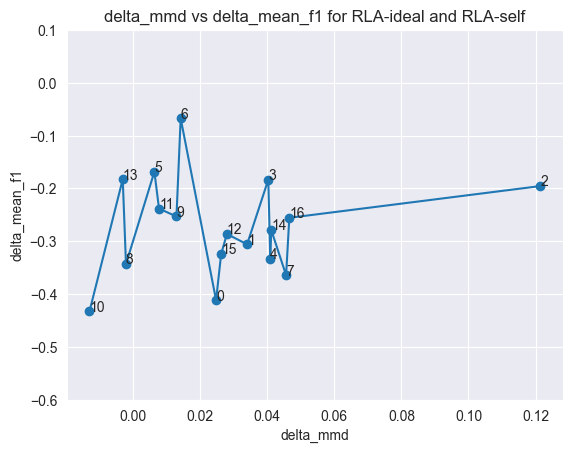

In [69]:
generate_delta_mmd_graph(train_device_1, train_device_2, 'attend')